<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/15wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상 

{{<video https://youtu.be/playlist?list=PLQqh36zP38-zesXx2Ad1CQF3V85SBnmcl&si=1N-UhzaPrEwP2sNn >}}

# 2. Imports 

In [14]:
#!apt-get install swig
#!pip install gymnasium[box2d]
import gymnasium as gym
#--#
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import IPython
#--#
import collections
import random
#--#
import torch

In [21]:
def show(ims,jump=10):
    ims = ims[::jump]
    fig = plt.Figure()
    ax = fig.subplots()
    def update(i):
        ax.imshow(ims[i])
    ani = FuncAnimation(fig,update,frames=len(ims))
    display(IPython.display.HTML(ani.to_jshtml()))

# 3. 예비학습 

## A. `collections.deque` 

`-` `collections.deque` 의 기능 

In [73]:
a = collections.deque([12,21,33], maxlen = 5)
a

deque([12, 21, 33], maxlen=5)

In [74]:
a.append(44)
a

deque([12, 21, 33, 44], maxlen=5)

In [75]:
a.append(55)
a

deque([12, 21, 33, 44, 55], maxlen=5)

In [76]:
a.append(-66)
a

deque([21, 33, 44, 55, -66], maxlen=5)

In [77]:
a.append(-40)
a

deque([33, 44, 55, -66, -40], maxlen=5)

`-` 단점? numpy array 보다는 list 느낌임 (연산에 특화된건 아님) 

In [78]:
a + 1

TypeError: can only concatenate deque (not "int") to deque

`-` 그렇지만 필요하다면 np.array 화 시킬 수 있음. 

In [79]:
np.array(a) + 1 

array([ 34,  45,  56, -65, -39])

In [80]:
torch.tensor(a) + 1

tensor([ 34,  45,  56, -65, -39])

`-` collection.deque 는 리플레이 버퍼를 구현할때 유용한 자료구조이다. 

- (우리가 했던) 기존방식: 모든 데이터를 저장하며 하나의 경험씩 학습함
- 리플레이버퍼: 최근 $N$개의 데이터를 저장하여 여러경험을 샘플링하여 학습하는 방식
- 리플레이버퍼의 장점: 메모리를 아낄 수 있다, 다양한 종류의 경험을 저장하고 무작위로 재사용하여 학습이 안정적으로 된다, "저장 -> 학습 -> 저장" 순으로 반드시 실시간으로 학습할 필요가 없어서 병렬처리에 용이하다, 강화학습에서 연속된 경험은 상관관계가 있을 수 있는데 무작위 샘플로 이러한 상관관계를 제거할 수 있음 

## B. `replay_buffer` 

In [81]:
current_states = collections.deque([torch.tensor([0.23,0.1]),torch.tensor([0.34,0.2])],maxlen=5)
actions = collections.deque([torch.tensor(0), torch.tensor(1)],maxlen=5)
rewards = collections.deque([torch.tensor(3.43), torch.tensor(0.13)],maxlen=5)
next_states = collections.deque([torch.tensor([0.34,0.2]),torch.tensor([0.45,0.3])],maxlen=5)
terminations = collections.deque([torch.tensor(False),torch.tensor(False)],maxlen=5)

In [82]:
current_states, actions,rewards,next_states,terminations

(deque([tensor([0.2300, 0.1000]), tensor([0.3400, 0.2000])], maxlen=5),
 deque([tensor(0), tensor(1)], maxlen=5),
 deque([tensor(3.4300), tensor(0.1300)], maxlen=5),
 deque([tensor([0.3400, 0.2000]), tensor([0.4500, 0.3000])], maxlen=5),
 deque([tensor(False), tensor(False)], maxlen=5))

In [83]:
memory = list(zip(current_states,actions,rewards,next_states,terminations))
memory

[(tensor([0.2300, 0.1000]),
  tensor(0),
  tensor(3.4300),
  tensor([0.3400, 0.2000]),
  tensor(False)),
 (tensor([0.3400, 0.2000]),
  tensor(1),
  tensor(0.1300),
  tensor([0.4500, 0.3000]),
  tensor(False))]

In [84]:
random.sample(memory,1)

[(tensor([0.2300, 0.1000]),
  tensor(0),
  tensor(3.4300),
  tensor([0.3400, 0.2000]),
  tensor(False))]

# 4. LunarLander 

`-` ref: <https://gymnasium.farama.org/environments/box2d/lunar_lander/>

`-` Lunar Lander: 요약

**Observation Space (State Space)** -- 8개의 변수 

1. 착륙선의 x 좌표
2. 착륙선의 y 좌표
3. 착륙선의 x 속도
4. 착륙선의 y 속도
5. 착륙선의 각도
6. 착륙선의 각속도
7. 왼쪽 다리가 땅에 닿아있는지 여부 (1 또는 0)
8. 오른쪽 다리가 땅에 닿아있는지 여부 (1 또는 0)

**Action Space** -- 4개의 변수

1. {0 : 아무 행동도 하지 않음}
2. {1 : 왼쪽 엔진 발사 (오른쪽으로 기울임)}
3. {2 : 메인 엔진 발사 (위로 밀어 올림)} 
4. {3 : 오른쪽 엔진 발사 (왼쪽으로 기울임)}

**Reward** 

- **거리 보상**: 착륙 패드에 가까울수록 보상 증가
- **속도 보상**: 속도가 낮을수록 보상 증가
- **각도 보상**: 각도가 수직에 가까울수록 보상 증가
- **착륙 다리 보상**: 다리가 착륙 패드에 닿으면 보상
- **연료 사용 패널티**: 엔진 사용 시 패널티
- **안전한 착륙 보상**: 안정적으로 착륙 시 큰 보상 (+100~+140)
- **충돌 패널티**: 착륙 패드 이외의 장소에 충돌 시 패널티 (-100)

`-` 환경생성 

In [85]:
env = gym.make("LunarLander-v2",render_mode = 'rgb_array')
env 

<TimeLimit<OrderEnforcing<PassiveEnvChecker<LunarLander<LunarLander-v2>>>>>

`-` state_space 

In [86]:
env.observation_space

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

In [87]:
env.observation_space.sample()

array([-1.2261683 , -0.64513946,  3.177441  ,  4.397604  ,  0.43389785,
        0.17615852,  0.79676867,  0.70889646], dtype=float32)

`-` action_space 

In [88]:
env.action_space

Discrete(4)

In [89]:
env.action_space.sample()

0

`-` env.reset()

In [90]:
state, _ = env.reset()
state 

array([ 0.00590591,  1.39996   ,  0.5981865 , -0.48712698, -0.00683666,
       -0.13549806,  0.        ,  0.        ], dtype=float32)

`-` env.render() 

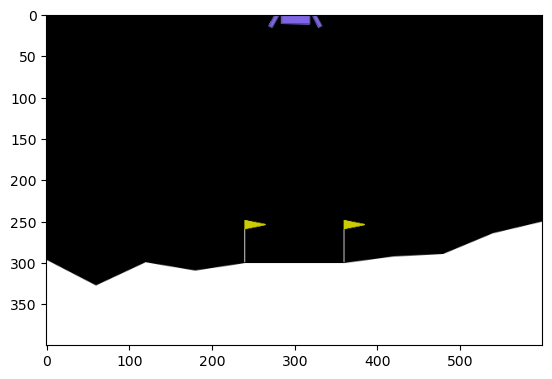

In [91]:
plt.imshow(env.render())

`-` env.step 

In [92]:
env.step??

Signature: env.step(action)
Source:   
    def step(self, action):
        """Steps through the environment and if the number of steps elapsed exceeds ``max_episode_steps`` then truncate.

        Args:
            action: The environment step action

        Returns:
            The environment step ``(observation, reward, terminated, truncated, info)`` with `truncated=True`
            if the number of steps elapsed >= max episode steps

        """
        observation, reward, terminated, truncated, info = self.env.step(action)
        self._elapsed_steps += 1

        if self._elapsed_steps >= self._max_episode_steps:
            truncated = True

        return observation, reward, terminated, truncated, info
File:      ~/anaconda3/envs/dl2024/lib/python3.11/site-packages/gymnasium/wrappers/time_limit.py
Type:      method

- 리턴되는 값은 (다음상태, 보상, 종료여부, 중단여부, 추가정보) 임.. 

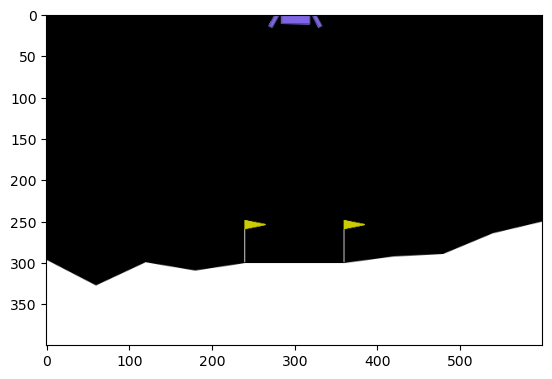

In [93]:
plt.imshow(env.render())

In [94]:
next_state, reward, terminated, _, _ = env.step(0)
next_state, reward, terminated

(array([ 0.01181202,  1.3884239 ,  0.5973786 , -0.5127587 , -0.01353233,
        -0.1339261 ,  0.        ,  0.        ], dtype=float32),
 -1.102008752296598,
 False)

`-` play 

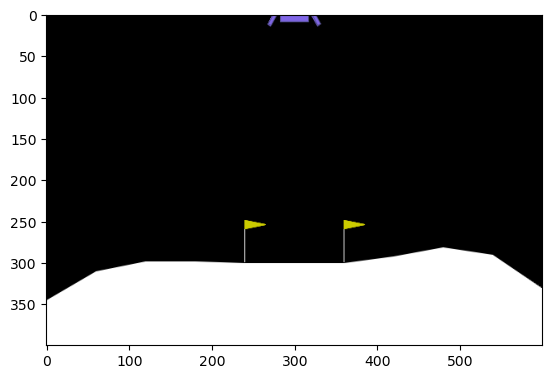

In [95]:
env.reset()
plt.imshow(env.render())

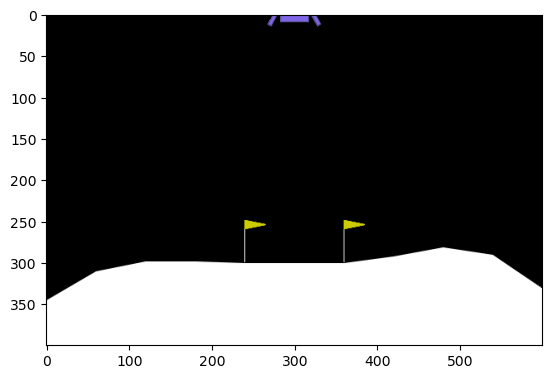

In [96]:
env.step(1)
plt.imshow(env.render())

- 0 : 아무행동도 하지 않음 
- 1 : 왼쪽 
- 2 : 위
- 3 : 오른쪽

# 5. 시각화 

In [97]:
current_state, _ = env.reset()
ims = [] 
for t in range(500): 
    action = env.action_space.sample()
    next_state, reward, terminated, _, _ = env.step(action)
    ims.append(env.render()) 
    current_state = next_state 
    if terminated: break 

In [98]:
show(ims) 

# 6. `AgentRandom`

In [99]:
env.step(0)

(array([ 0.38440236, -0.13146968,  1.0653406 , -0.15023416, -0.9695563 ,
        -1.5373656 ,  0.        ,  0.        ], dtype=float32),
 -100,
 True,
 False,
 {})

In [15]:
class AgentRandom: 
    def __init__(self,env):
        #--# define spaces 
        self.action_space = env.action_space
        self.state_space = env.observation_space
        #--# replay buffer 
        self.current_state =  None    ## 길이가 8인 np.array        
        self.action = None            ## int, 0,1,2,3 중 하나
        self.reward = None            ## float  
        self.next_state =  None       ## np.array
        self.terminated = None        ## bool 
        #-#
        self.buffer_size = 5000 
        self.current_states = collections.deque(maxlen=self.buffer_size) # 원소는 텐서         
        self.actions = collections.deque(maxlen=self.buffer_size) # 원소는 텐서 
        self.rewards = collections.deque(maxlen=self.buffer_size) # 원소는 텐서
        self.next_states = collections.deque(maxlen=self.buffer_size) # 원소는 텐서 
        self.terminations = collections.deque(maxlen=self.buffer_size) # 원소는 텐서 
        #--# other information 
        self.n_episodes = 0         
        self.n_experiences = 0
        self.playtimes = [] 
        self.score = 0                
        self.scores = []
    def act(self):
        self.action = self.action_space.sample()
    def learn(self):
        pass 
    def save_experience(self):
        self.current_states.append(torch.tensor(self.current_state))
        self.actions.append(torch.tensor(self.action))
        self.rewards.append(torch.tensor(self.reward))
        self.next_states.append(torch.tensor(self.next_state))
        self.terminations.append(torch.tensor(self.terminated))           
        #--#
        self.n_experiences = self.n_experiences + 1 
        self.score = self.score + self.reward

In [101]:
env = gym.make("LunarLander-v2",render_mode = 'rgb_array')
agent = AgentRandom(env)
#--#
for _ in range(500): 
    agent.current_state,_ = env.reset()
    agent.score = 0
    for t in range(1,1001):
        ## step1: 행동 
        agent.act()
        ## step2: 보상
        agent.next_state, agent.reward, agent.terminated, _, _ = env.step(agent.action)
        ## step3: 저장 & 학습 
        agent.save_experience()
        agent.learn()
        ## step4: 
        agent.current_state = agent.next_state 
        if agent.terminated: break 
    agent.scores.append(agent.score) 
    agent.playtimes.append(t) 
    agent.n_episodes = agent.n_episodes + 1 
    #---#
    logfreq = 100
    if (agent.n_episodes % logfreq) == 0: 
        print(
            f"에피소드:{agent.n_episodes}\t"
            f"경험(t):{agent.n_experiences}\t"            
            f"점수(에피소드):{np.mean(agent.scores[-logfreq:]):.2f}\t"
            f"게임시간(에피소드):{np.mean(agent.playtimes[-logfreq:]):.2f}"
        )    

에피소드:100	경험(t):9227	점수(에피소드):-187.87	게임시간(에피소드):92.27
에피소드:200	경험(t):19217	점수(에피소드):-180.42	게임시간(에피소드):99.90
에피소드:300	경험(t):28415	점수(에피소드):-195.30	게임시간(에피소드):91.98
에피소드:400	경험(t):37470	점수(에피소드):-179.93	게임시간(에피소드):90.55
에피소드:500	경험(t):46602	점수(에피소드):-195.32	게임시간(에피소드):91.32


# 7. `AgentExplorer`

## A. `q_net`

`-` 전략: 4x4에서 `q_table`에 대응하는 정보가 있으면 된다. 그런데 `q_table`와 같이 테이블 형식으로는 힘들것 같다. $\to$ `q_net`를 만들자.

- 4x4 grid: 상태공간의 차원은 2차원이며 가질수 있는 값은 16개, 각 상태공간에서 할수 있는 행동이 4개 -> 총 16*4의 경우의 수에 대한 reward만 조사하면 되었음
- LunarLander: 상태공간의 차원은 8차원이지만 가질수 있는 값의 범위는 무한대 -> 무수히 많은 경우에 대한 reward 값을 조사하는건 현실적으로 불가능 

`-` 4x4 코드 

```Python
class AgentGreedy(AgentRandom):
    def __init__(self,env):
        super().__init__(env)
        #--#
        self.q_table = np.zeros([4,4,4])
    def learn(self): # q_table 
        s1,s2 = self.current_state
        ss1,ss2 = self.next_state
        a = self.action
        r = self.reward
        q_hat = self.q_table[s1,s2,a] 
        if self.terminated:
            q = r 
        else:
            future_reward = self.q_table[ss1,ss2,:].max()
            q = r + 0.99 * future_reward 
        diff = q - q_hat
        self.q_table[s1,s2,a] = q_hat + 0.05 * diff         
    def act(self):
        if self.n_experiences < 3000:
            self.action = self.action_space.sample()
        else: 
            s1,s2 = self.current_state 
            self.action = self.q_table[s1,s2,:].argmax()
```

`수정 1`. `agent.q_table` 에 대응하는 과정 

In [102]:
agent.q_net = torch.nn.Sequential(
    torch.nn.Linear(8,256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,64),
    torch.nn.ReLU(),    
    torch.nn.Linear(64,4)
)    

In [103]:
agent.q_net # <- 8개의 숫작가 들어가면 4개의 숫자가 나옴 

Sequential(
  (0): Linear(in_features=8, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=4, bias=True)
)

In [104]:
s = torch.tensor(agent.current_state)
agent.q_net(s)

tensor([0.0175, 0.0499, 0.1191, 0.0083], grad_fn=<ViewBackward0>)

- `q_net`은 8개의 숫자가 입력으로 오면 4개의 숫자가 리턴되는 함수이다. 
- 해석을 하면 8개의 숫자는 state를 나타내는 숫자로 이해할 수 있고 4개의 숫자는 각 action에 대한 q값으로 해석할 수 있다.
- 출력되는 4개의 숫자는 합리적인 숫자가 아님 (최초의 숫자임) 그렇지만 데이터를 학습하여 점점 합리적으로 변할 것임. 

`2`. `q_hat`

In [105]:
s = torch.tensor(agent.current_state)
a = torch.tensor(agent.action)
q_hat = agent.q_net(s)[a]

In [106]:
q_hat

tensor(0.1191, grad_fn=<SelectBackward0>)

`3`. `q` ($q = r + 0.99 \times {\tt future\_reward}$)

In [107]:
s = torch.tensor(agent.current_state)
a = torch.tensor(agent.action)
r = torch.tensor(agent.reward)
ss = torch.tensor(agent.next_state)

In [108]:
if agent.terminated:
    q = r
else:
    future_reward = agent.q_net(ss).max().data
    q = r + 0.99 * future_reward 

`4`. `q_hat` 을 점점 `q` 와 비슷하게 만드는 과정

In [109]:
memory = list(zip(agent.current_states,agent.actions,agent.rewards,agent.next_states,agent.terminations))

In [110]:
agent.batch_size = 4 
minibatch = random.sample(memory,agent.batch_size)
minibatch[0] # s,a,r,ss,t 

(tensor([-0.0827,  0.4462, -0.4321, -1.1998,  0.7915,  0.1979,  0.0000,  0.0000]),
 tensor(1),
 tensor(-1.9897, dtype=torch.float64),
 tensor([-0.0871,  0.4186, -0.4399, -1.2323,  0.8041,  0.2514,  0.0000,  0.0000]),
 tensor(False))

In [111]:
agent.optimizr = torch.optim.Adam(agent.q_net.parameters())
for epoc in range(5):
    memory = list(zip(agent.current_states,agent.actions,agent.rewards,agent.next_states,agent.terminations))
    minibatch = random.sample(memory,agent.batch_size)
    ## step 1~2 
    loss = 0 
    for s,a,r,ss,terminated in minibatch:
        # step1: q_hat 
        q_hat = agent.q_net(s)[a]        
        # step2: loss를 계산한다. 
        if agent.terminated:
            q = r
        else:
            future_reward = agent.q_net(ss).max().data
            q = r + 0.99 * future_reward
        loss = loss + (q_hat-q)**2 
    loss = loss / agent.batch_size 
    # step3 
    loss.backward()
    # step4 
    agent.optimizr.step()
    agent.optimizr.zero_grad() 

`5`. 행동..? 

In [112]:
agent.q_net(s).argmax().item()

2

In [113]:
agent.eps = 0.5 
if np.random.rand() < agent.eps: 
    agent.action = agent.action_space.sample()
else: 
    s = torch.tensor(agent.current_state)
    agent.q_net(s).argmax().item()    

## B. 클래스의 설계 

In [16]:
class AgentExplorer(AgentRandom):
    def __init__(self,env):
        super().__init__(env)
        self.eps = 0 
        self.q_net = torch.nn.Sequential(
            torch.nn.Linear(8,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),    
            torch.nn.Linear(64,4)
        )
        self.optimizr = torch.optim.Adam(self.q_net.parameters(),lr=0.0001)
        self.batch_size = 64
    def act(self):
        if np.random.rand() < self.eps: 
            self.action = self.action_space.sample()
        else: 
            s = torch.tensor(self.current_state)
            self.action = self.q_net(s).argmax().item() 
    def learn(self):
        if self.n_experiences < self.batch_size:
            pass 
        else: 
            for epoc in range(1):
                memory = list(zip(
                    self.current_states,
                    self.actions,
                    self.rewards,
                    self.next_states,
                    self.terminations
                ))
                minibatch = random.sample(memory,self.batch_size)
                ## step 1~2 
                loss = 0 
                for s,a,r,ss,terminated in minibatch:
                    # step1: q_hat 
                    q_hat = self.q_net(s)[a]        
                    # step2: loss를 계산한다. 
                    if self.terminated:
                        q = r
                    else:
                        future_reward = self.q_net(ss).max().data
                        q = r + 0.99 * future_reward
                    loss = loss + (q_hat-q)**2 
                loss = loss / self.batch_size 
                # step3 
                loss.backward()
                # step4 
                self.optimizr.step()
                self.optimizr.zero_grad() 

## C. 환경과 상호작용 

In [70]:
env = gym.make("LunarLander-v2",render_mode = 'rgb_array')
agent = AgentExplorer(env)
agent.eps = 1 
#--#
for _ in range(2000): 
    # STEP1: 에피소드 준비 
    agent.current_state,_ = env.reset()
    agent.score = 0
    # STEP2: 에피소드 진행 
    for t in range(1,1001):
        ## step1: 행동 
        agent.act()
        ## step2: 보상
        agent.next_state, agent.reward, agent.terminated, _, _ = env.step(agent.action)
        ## step3: 저장 & 학습 
        agent.save_experience()
        agent.learn()
        ## step4: 
        agent.current_state = agent.next_state 
        if agent.terminated: break 
    # STEP3: 다음에피소드준비 
    agent.scores.append(agent.score) 
    agent.playtimes.append(t) 
    agent.n_episodes = agent.n_episodes + 1
    agent.eps = agent.eps * 0.995 
    if np.mean(agent.scores[-100:]) > 200: 
        print(f"---game cleared in {agent.n_episodes} episodes! ---")
        torch.save(agent.q_net.state_dict(),f"q_net_final.pth")
        break 
    #---#
    logfreq = 100
    if (agent.n_episodes % logfreq) == 0: 
        print(
            f"에피소드:{agent.n_episodes}\t"
            f"경험(t):{agent.n_experiences}\t"            
            f"점수(에피소드):{np.mean(agent.scores[-logfreq:]):.2f}\t"
            f"게임시간(에피소드):{np.mean(agent.playtimes[-logfreq:]):.2f}\t"
            f"돌발행동(에피소드):{agent.eps:.2f}"
        )
        torch.save(agent.q_net.state_dict(),f"q_net_{agent.n_episodes}.pth")

에피소드:100	경험(t):10838	점수(에피소드):-176.71	게임시간(에피소드):108.38	돌발행동(에피소드):0.61
에피소드:200	경험(t):51270	점수(에피소드):-56.40	게임시간(에피소드):404.32	돌발행동(에피소드):0.37
에피소드:300	경험(t):127024	점수(에피소드):97.89	게임시간(에피소드):757.54	돌발행동(에피소드):0.22
에피소드:400	경험(t):181605	점수(에피소드):161.62	게임시간(에피소드):545.81	돌발행동(에피소드):0.13
---game cleared in 468 episodes!---


---

***아래코드 실행하면 제가 실습에 사용한 파일 받아올수있어요*** 

```Python
!wget https://github.com/guebin/DL2024/raw/main/posts/LunarLander/q_net_100.pth
!wget https://github.com/guebin/DL2024/raw/main/posts/LunarLander/q_net_200.pth
!wget https://github.com/guebin/DL2024/raw/main/posts/LunarLander/q_net_300.pth
!wget https://github.com/guebin/DL2024/raw/main/posts/LunarLander/q_net_400.pth
!wget https://github.com/guebin/DL2024/raw/main/posts/LunarLander/q_net_final.pth
```

---

In [31]:
agent_dummy = AgentExplorer(env) 
#agent_dummy.q_net = agent.q_net # 비법전수 
agent_dummy.q_net.load_state_dict(torch.load("q_net_final.pth"))

agent_dummy.current_state, _ = env.reset()
agent_dummy.terminated = False 
ims = [] 
ims.append(env.render())
for t in range(1001):
    agent_dummy.act() 
    agent_dummy.next_state, agent_dummy.reward, agent_dummy.terminated, _, _  = env.step(agent_dummy.action)
    ims.append(env.render())
    agent_dummy.current_state = agent_dummy.next_state
    if agent_dummy.terminated: break 

In [32]:
show(ims)

# A1. 신경망관련 용어

`-` 은근히 용어가 헷갈리는데, 뜻을 좀 살펴보자. 

- ANN: 인공신경망 
- MLP: 다층퍼셉트론 (레이어가 여러개 있어요) 
- DNN: 깊은신경망, 심층신경망 
- CNN: 합성곱신경망 
- RNN: 순환신경망 

`# 예시1` -- MLP, DNN

```Python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=1),    
    torch.nn.Sigmoid()
)
```

- ANN: O
- MLP: O 
- DNN: O
- CNN: X (합성곱레이어가 없으므로) 
- RNN: X (순환구조가 없으므로)

`#`

`# 예시2` -- MLP, Shallow Network

```Python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=1),
    torch.nn.Sigmoid()
)
```

- ANN: O
- MLP: O 
- DNN: X? (깊은 신경망으로 생각하려면 더 많은 레이어가 필요함. 합의된 기준은 히든레이어 2장이상, 이걸 설명하기 위해서 얕은 신경망이란 용어도 씀) 
- CNN: X (합성곱레이어가 없으므로) 
- RNN: X (순환구조가 없으므로)

`#`

`# 예시3` -- MLP, DNN, Wide NN

```Python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1048576),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=1048576,out_features=1048576),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=1048576,out_features=1),
    torch.nn.Sigmoid(),    
)
```

- ANN: O
- MLP: O 
- DNN: O? (깊긴한데 이정도면 모양이 깊다기 보다는 넓은 신경망임, 그래서 어떤 연구세어는 이걸 넓은 신경망이라 부르기도 함) 
- CNN: X (합성곱레이어가 없으므로) 
- RNN: X (순환구조가 없으므로)

`# 예시4` -- CNN

```Python
net = torch.nn.Sequential(
    # Layer1
    torch.nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.LeakyReLU(0.2),
    # Layer2
    torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(128),
    torch.nn.LeakyReLU(0.2),
    # Layer3
    torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(256),
    torch.nn.LeakyReLU(0.2),
    # Layer4
    torch.nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(512),
    torch.nn.LeakyReLU(0.2),
    # Layer5
    torch.nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    torch.nn.Sigmoid(),
    torch.nn.Flatten()
)
```

- ANN: O
- MLP: X (합성곱연결이 포함되어있으므로, MLP가 아님, 완전연결만 포함해야 MLP임)  
- DNN: O
- CNN: O (합성곱레이어를 포함하고 있으므로) 
- RNN: X (순환구조가 없으므로)

`# `

`# 예시5` -- CNN 

```Python
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
```

- ANN: O
- MLP: X 
- DNN: X? (히든레이어가 1장이므로..)
- CNN: O (합성곱레이어를 포함하고 있으므로) 
- RNN: X (순환구조가 없으므로)

> 근데 대부분의 문서에서는 CNN, RNN은 DNN의 한 종류로 설명하고 있어서요.. 이런 네트워크에서는 개념충돌이 옵니다. 

`#`

`# 예시6` -- RNN

```Python
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = torch.nn.RNN(4,2)
        self.linr = torch.nn.Linear(2,2) 
    def forward(self,X):
        h = self.rnn(X) 
        netout = self.linr(h)
        return netout 
net = Net()     
```

- ANN: O
- MLP: X 
- DNN: X? (히든레이어가 1장이므로..)
- CNN: X (합성곱레이어가 없으므로) 
- RNN: O

> 이것도 비슷한 개념충돌 

`#`

# A2. 학습 

`-` 모든 인공지능 관련 알고리즘은 아래의 분류로 가능함. 

| **특징**            | **지도학습 (Supervised Learning)** | **비지도학습 (Unsupervised Learning)** | **강화학습 (Reinforcement Learning)** |
|:---------------------:|:-------------------------------------:|:----------------------------------------:|:---------------------------------------:|
| **정의**            | 입력 데이터와 정답(레이블)을 사용   | 입력 데이터만 사용                      | 에이전트가 환경과 상호작용하며 학습   |
| **목표**            | 입력에 대한 정확한 출력을 예측      | 데이터의 숨겨진 구조나 패턴 발견       | 최대 보상을 얻기 위한 최적의 정책 학습 |
| **예시**            | 이미지 분류, 스팸 필터링            | 군집화, 차원 축소                       | 게임 플레이, 로봇 제어                 |
| **주요 알고리즘**   | 선형 회귀, 로지스틱 회귀, SVM       | K-평균, PCA, 오토인코더                | Q-러닝, DQN, 정책 경사 방법            |
| **활용**            | 분류, 예측              | 데이터의 숨겨진 패턴 발견               | 복잡한 의사결정 문제 해결 가능         |
| **데이터 요구사항** | 레이블링이 반드시 필요           | 많은 양의 데이터 필요                  | 시뮬레이션 또는 실제 환경 필요         |


`-` 그런데 사실 불가능함 